In [18]:
import pandas as pd
import networkx as nx

# Charger les fichiers
df_edges = pd.read_csv("../Data/processed/trajets_stations_pollution.csv")
df_nodes = pd.read_csv("../Data/processed/stations_qgis.csv")

# Nettoyage des noms (strip des espaces inutiles)
df_nodes['Nom de la Station'] = df_nodes['Nom de la Station'].str.strip()
df_edges['station1'] = df_edges['station1'].str.strip()
df_edges['station2'] = df_edges['station2'].str.strip()


In [25]:
# Création du graphe
G = nx.Graph()

# Ajout des noeuds avec leurs attributs
for _, row in df_nodes.iterrows():
    station = row['Nom de la Station']
    pollution_num = row['pollution_num']
    lat = row['stop_lat']
    lon = row['stop_lon']
    G.add_node(station, pollution=pollution_num, latitude=lat, longitude=lon)

# Ajout des arêtes avec les attributs pollution et temps
for _, row in df_edges.iterrows():
    station1 = row['station1']
    station2 = row['station2']   
    # Vérification : les deux stations doivent exister comme noeuds
    if station1 in G.nodes and station2 in G.nodes:
        G.add_edge(station1, station2)

# Résumé du graphe
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
sample_nodes = list(G.nodes(data=True))[:5]

nb_nodes, nb_edges, sample_nodes

(320,
 378,
 [('Arts et Métiers',
   {'pollution': 2.0,
    'latitude': 48.86529961264491,
    'longitude': 2.3565081436435467}),
  ('Avron',
   {'pollution': 2.0,
    'latitude': 48.85164854359716,
    'longitude': 2.3981875566593973}),
  ('Barbès - Rochechouart',
   {'pollution': 2.0,
    'latitude': 48.88385234986188,
    'longitude': 2.350573400888514}),
  ('Boissière',
   {'pollution': 2.0,
    'latitude': 48.8668483434173,
    'longitude': 2.2900328376074373}),
  ('Botzaris',
   {'pollution': 2.0,
    'latitude': 48.879534991268365,
    'longitude': 2.388900951315739})])

In [28]:
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh

# Matrice d’adjacence binaire (poids = 1 si connecté)
A = nx.to_numpy_array(G, weight=None)

# Calcul du Laplacien normalisé
L = laplacian(A, normed=True)

# Décomposition spectrale
eigvals, eigvecs = eigh(L)

# Affichage des 10 plus petites valeurs propres
eigvals[:10]


array([-2.22044605e-16,  5.22569363e-03,  6.52784404e-03,  8.54724917e-03,
        9.86096580e-03,  1.22628036e-02,  1.46132262e-02,  1.68698290e-02,
        1.82748295e-02,  2.07356027e-02])

[ 3.60230545e-02  4.72884735e-02  3.50544983e-02 -6.29247274e-02
  6.54276494e-02 -7.06753092e-02 -1.64900077e-01  9.78521119e-03
 -1.38047521e-02  3.85435258e-03 -1.63992214e-02  1.34433248e-02
 -7.90770415e-02 -9.07945677e-02  3.53712447e-02  2.33730390e-02
  2.01747673e-02  9.02968488e-04 -3.35238509e-02 -3.66880306e-02
  5.42737966e-02 -5.33864740e-02  1.21035699e-01  5.33724220e-02
 -6.08545045e-02  1.71753039e-02  3.46450194e-02 -4.72134834e-02
  3.89690987e-02  6.60892819e-02  1.99331267e-02  4.38955239e-02
 -4.42546016e-02  3.73707349e-02  1.01003524e-02 -4.62436987e-02
 -1.18474143e-01  6.50255599e-02 -1.03366101e-01 -9.54400435e-02
  1.43460330e-02 -1.57409491e-02 -5.83170958e-02 -1.18565143e-02
 -1.25184943e-02  6.87688954e-02  2.29386910e-02  1.35830178e-01
  1.29107616e-01  3.07089740e-02  2.28451871e-02 -1.90008882e-01
 -8.76010345e-02  7.94915547e-02 -4.07048623e-02 -3.40283485e-04
 -7.08987729e-02  6.85508200e-02 -1.54894588e-02  2.45410719e-02
  4.94924670e-03 -2.05312

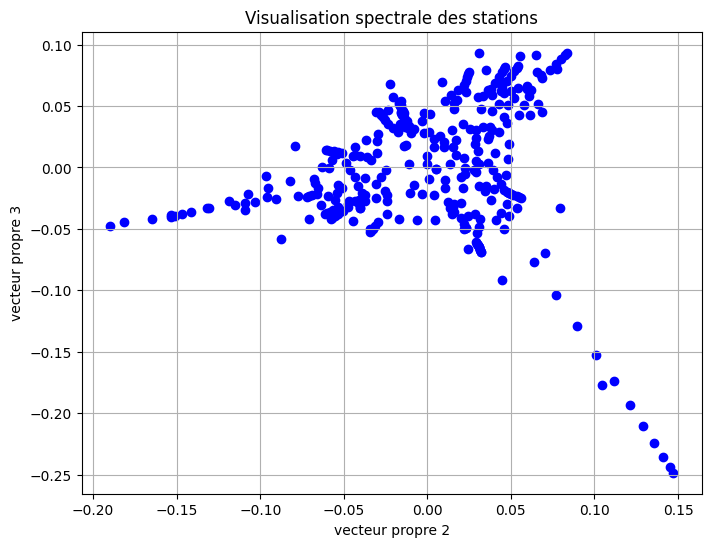

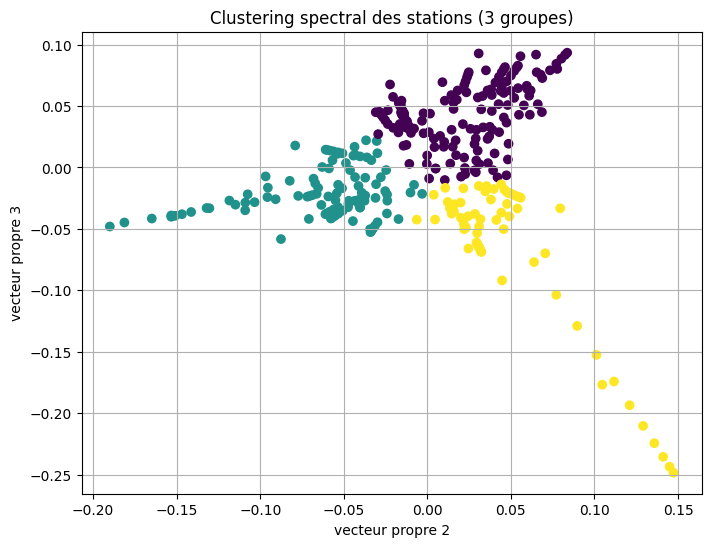

In [30]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#on choisit les vecteurs propres 2 et 3 (pas celui de valeur 0); ces vecteurs montrent les directions principales dans le graphe

vec2 = eigvecs[:, 1]  # 2eme plus petit vecteur propre
vec3 = eigvecs[:, 2]  # 3eme plus petit vecteur propre

print(vec2, vec3)

#  on fait un nuage de points, chaque point est une station, les couleurs representent les zones qui reagissent pareil a la pollution

plt.figure(figsize=(8, 6))
plt.scatter(vec2, vec3, c='blue')
plt.xlabel("vecteur propre 2")
plt.ylabel("vecteur propre 3")
plt.title("Visualisation spectrale des stations")
plt.grid(True)
plt.show()

# clustering avec KMeans pour regrouperr les stations en 3 groupes selon leur position dans le plan spectral

X = np.vstack((vec2, vec3)).T  # on met les deux vecteurs ensemble
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X)

# meme graphe mais avec couleurs selon les clusters trouves
plt.figure(figsize=(8, 6))
plt.scatter(vec2, vec3, c=labels, cmap='viridis')
plt.xlabel("vecteur propre 2")
plt.ylabel("vecteur propre 3")
plt.title("Clustering spectral des stations (3 groupes)")
plt.grid(True)
plt.show()


In [31]:
from sklearn.cluster import KMeans
import pandas as pd

# on applique un clustering k-means sur les vecteurs propres 2 et 3
kmeans = KMeans(n_clusters=3, random_state=0).fit(eigvecs[:, 1:3])
labels = kmeans.labels_

# on reliste les noms des stations et leur cluster (groupe spectral)
# on utilise df_merged qui contient les noms de stations connectees

# on prend tous les noms de stations dans l'ordre du graphe
stations = list(G.nodes)

# on fait un tableau avec les noms de stations et leur groupe spectral
df_clusters = pd.DataFrame({
    "station": stations,
    "cluster": labels
})

# on affiche les 10 premieres lignes pour verifier
df_clusters.head(10)

# on recupere l'ordre exact des noeuds dans la matrice A
# cet ordre est le meme que celui utilise pour les vecteurs propres
station_order = list(G.nodes)  # on garde l’ordre des nœuds tel qu’il est dans G

# on recalcule proprement l'ordre des stations depuis le graphe
station_list = list(G.nodes())

# on fait un tableau correct avec les labels de cluster selon l'ordre des vecteurs propres
df_clusters_corrected = pd.DataFrame({
    "station": station_list,
    "cluster": labels
})

# on compte le nombre de stations par cluster
df_clusters_corrected['cluster'].value_counts().sort_index()


cluster
0    208
1    100
2     12
Name: count, dtype: int64

In [33]:
# Lister les stations par cluster
stations_by_cluster = df_clusters_corrected.groupby("cluster")["station"].apply(list)

# Recuperer les coordonnees depuis df_nodes pour QGIS
# On prend toutes les stations avec leur pollution et leurs coordonnees

# On extrait les infos géographiques et pollution
stations_geo = df_nodes[["Nom de la Station", "pollution_num", "stop_lat", "stop_lon"]].rename(
    columns={
        "Nom de la Station": "station",
        "pollution_num": "pollution",
        "stop_lat": "lat",
        "stop_lon": "lon"
    }
)

# Joindre les clusters
stations_geo_clustered = pd.merge(df_clusters_corrected, stations_geo, on="station", how="left")

# Graphe spectral coloré par pollution (par station)
# On récupère les coordonnées spectrales (vecteurs propres)
station_list = list(G.nodes())
df_plot = pd.DataFrame({
    "station": station_list,
    "x": eigvecs[:, 1],
    "y": eigvecs[:, 2]
})

# Fusion avec pollution réelle par station (depuis df_nodes)
df_plot = pd.merge(df_plot, stations_geo[["station", "pollution"]], on="station", how="left")

# Ecriture d'une analyse auto + affichage resultat tableau QGIS
stations_geo_clustered.to_csv("../Data/processed/stations_qgis_clusters.csv", index=False)

# Affichage résultats
stations_by_cluster, df_plot.head()


(cluster
 0    [Arts et Métiers, Avron, Barbès - Rochechouart...
 1    [Boissière, Boucicaut, Boulogne Jean Jaurès, C...
 2    [Ecole Vétérinaire de Maisons-Alfort, Maisons-...
 Name: station, dtype: object,
                  station         x         y  pollution
 0        Arts et Métiers  0.036023  0.023237        1.0
 1        Arts et Métiers  0.036023  0.023237        2.0
 2                  Avron  0.047288 -0.006397        2.0
 3  Barbès - Rochechouart  0.035054  0.079034        1.0
 4  Barbès - Rochechouart  0.035054  0.079034        2.0)